<a href="https://colab.research.google.com/github/adeiltonmsantos/DataHandler/blob/main/DataHandler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

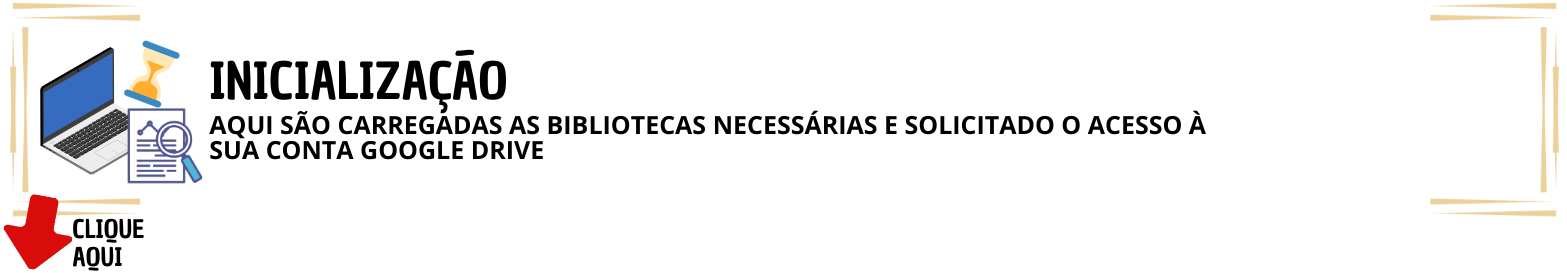

In [2]:
# @title
!pip install pdfplumber
!pip install pyspark
!pip install google-generativeai
!pip install tabulate==0.9.0

# @title CARREGANDO O MANIPULADOR DE DADOS
import pdfplumber
import pandas as pd
import google.generativeai as genai
from google.colab import files
from pyspark import SparkContext
import ast
import os
import time
import datetime as dtm
import tabulate as tb
from IPython.display import clear_output
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

clear_output()
print('BIBLIOTECAS CARREGADAS COM SUCESSO!')
time.sleep(3)
clear_output()

# Função para imprimir mensagem, dado um título (title) e uma string para a
# mensagem (msg). O parâmetro opcional 'delay', se informado, faz a mensagem
# desaparecer após o valor informado de 'delay' em segundos. Se 'title' for uma
# lista, cada valor representa o rótulo de uma coluna e 'msg' deve ser uma lista
# de listas, cada uma dessas listas uma linha (a mensagem toda será uma tabela)
def printMessage(msg, title, delay=0):
  if type(msg) is list:
    print(tb.tabulate(msg, headers=title, tablefmt='fancy_grid'))
  else:
    print(tb.tabulate([[msg]], headers=[title], tablefmt='fancy_grid'))
  if delay > 0:
    time.sleep(delay)
    clear_output()

# Tentando acesso à conta Google Drive...
try:
  if not os.path.isdir('/content/drive'):
    drive.mount('/content/drive')

  DIR_PROJECT = '/content/drive/MyDrive/Colab Notebooks/DataHandler'

  # Verificando se existe a pasta do projeto. Se não existir, cria
  if os.path.isdir(DIR_PROJECT) == False:
    os.mkdir(DIR_PROJECT)
    # Movendo o arquivo DataHandler.ipynb recém uploaded para a pasta do projeto
    uploaded_file = '/content/drive/MyDrive/Colab Notebooks/DataHandler.ipynb'
    new_file = DIR_PROJECT + '/DataHandler.ipynb'
    os.rename(uploaded_file, new_file)

  # Verificando se existe a pasta de análise de dados. Se não exisitir, cria
  if not os.path.isdir(DIR_PROJECT + '/analysis'):
    os.mkdir(DIR_PROJECT + '/analysis')
except:
  print('Alguma instabilidade na rede não permitiu acesso ao Google Drive')
  print('Execute esta célula mais uma vez')

# Criando arquivo txt com chave de API Gemini, se não existir
try:
  if not os.path.exists(DIR_PROJECT + '/gemini-api-key.txt'):
    clear_output()
    msg = 'Você ainda não salvou a chave de API Gemini. Ela é necessária para que'
    msg += '\na aplicação funcione corretamente. Copie sua chave na página do Google'
    msg += '\nAI Studio em https://aistudio.google.com/app/u/1/apikey. Em seguida,'
    msg += '\ndigite ou cole logo abaixo'
    printMessage(msg, 'ATENÇÃO!')
    print('\n')
    key_gemini = input('Digite ou cole aqui sua chave do API Gemini: ')
    with open(DIR_PROJECT + '/gemini-api-key.txt', 'w') as f:
      f.write(key_gemini)
    msg = 'Chave de API Gemini salva com sucesso!'
    printMessage(msg, 'OPERAÇÃO CONCLUÍDA!', delay=4)
except KeyboardInterrupt:
  clear_output()
except Exception:
  pass

# Salvando o arquivo txt com o modelo de prompt da IA do Google, se ainda não
# foi feito
if not os.path.exists(DIR_PROJECT + '/gemini-model.txt'):
  try:
    !wget -P "$DIR_PROJECT" "https://raw.githubusercontent.com/adeiltonmsantos/DataHandler/refs/heads/main/gemini-model.txt"
    clear_output()
  except Exception:
    title = 'ERRO NO CARREGAMENTO DE CÓDIGO DE IA'
    msg = 'Ocorreu um erro na rede durante o carregamento de'
    msg += '\ncódigo de IA. Execute esta célula novamente caso'
    msg += '\ncontrário a ferramenta não funcionará\ncorretamente'
    printMessage(msg, title=title)


class DataHandler:
  def __init__(self, dt=False, filename=None, coment=None):

    # Carregando chave da API Gemini
    with open(DIR_PROJECT + '/gemini-api-key.txt', 'r') as f:
      genai.configure(api_key=f.read().strip())

    # Carregando modelo de prompt Gemini do arquivo txt
    with open(DIR_PROJECT + '/gemini-model.txt', 'r') as f:
      self.gemini_model = f.read()

    # String com data/hora não informada (novos dados). Criando nova string...
    if dt is False:
      dt_hr = dtm.datetime.now()
      lst_dt = str(dt_hr).split(' ')
      self.dt = lst_dt[0] + '|' + lst_dt[1]
      # DataFrame Pandas com todos os dados
      self.filename = filename
      self.full_df = self.miningDataInPDF()
      # DataFrame Pandas com todos os reprovados
      self.reprov_df = None
      # DataFrame c/ reprovados por segmento
      self.reprov_classif_df = None
      # Salvando comentário
      self.coment = coment
      with open(DIR_PROJECT + '/analysis/' + self.dt + '/coment.txt', 'w') as f:
        f.write(self.coment)

    # String com data/hora foi informado. Carregando dados salvos em CSVs...
    else:
      self.dt = dt
      # DataFrame Pandas com todos os dados
      try:
        self.full_df = pd.read_csv(DIR_PROJECT + '/analysis/' + self.dt + '/full_data.csv')
      except Exception:
        self.full_df = None
      # DataFrame Pandas com todos os reprovados
      try:
        self.reprov_df = pd.read_csv(DIR_PROJECT + '/analysis/' + self.dt + '/reprov_data.csv')
      except Exception:
        self.reprov_df = None
      # DataFrame c/ reprovados por segmento
      try:
        self.reprov_classif_df = pd.read_csv(DIR_PROJECT + '/analysis/' + self.dt + '/classif_reprov_data.csv')
      except Exception:
        self.reprov_classif_df = None

      self.filename = None

    # Tamamanho do bloco de dados analisados de uma vez c/ IA p/ obter segmentos
    self.batch_size = 450

    # Verificando se a pasta dos dados já existe. Se não existir, cria
    if not os.path.isdir(DIR_PROJECT + '/analysis/' + self.dt):
      os.mkdir(DIR_PROJECT + '/analysis/' + self.dt)


  # df_name pode ser 'df_full', 'df_reprov', 'df_classif'
  def __existsDataFrame(self, df_name):
    match df_name:
      case 'df_full':
        try:
          self.df_full = pd.read_csv(DIR_PROJECT + '/analysis/' + self.dt + '/full_data.csv')
          return True
        except FileNotFoundError:
          return False
      case 'df_reprov':
        try:
          self.df_reprov = pd.read_csv(DIR_PROJECT + '/analysis/' + self.dt + '/reprov_data.csv')
          return True
        except FileNotFoundError:
          return False
      case 'df_classif':
        try:
          self.df_classif = pd.read_csv(DIR_PROJECT + '/analysis/' + self.dt + '/classif_reprov_data.csv')
          return True
        except FileNotFoundError:
          return False
      case _:
        return False

  # Retorna datas inicial e final dos dados brutos e monta label para gráfico de
  # Pareto com 'De ##/##/#### a ##/##/####'
  def __labelGraphDates(self):
    df = self.full_df['data'].apply(lambda x: dt.strptime(x, '%d/%m/%y'))
    dt_ini = df.min().strftime('%d/%m/%Y')
    dt_fim = df.max().strftime('%d/%m/%Y')
    return dt_ini + ' a ' + dt_fim


  # Retorna DataFrame Pandas com todos os resultados
  def miningDataInPDF(self):

    if self.__existsDataFrame('df_full'):
      return self.full_df
    else:
      # Extraindo páginas do PDF
      pgs = pdfplumber.open(self.filename).pages

      # Tabela temporária para usar no loop
      tb = None

      # DataFrame Pandas temporário para usar no loop com 12 colunas
      df_temp = pd.DataFrame()

      # DataFrame Pandas para todos os dados
      df = pd.DataFrame()

      # Lista com itens problemáticos encontrados na criação do DataFrame
      list_problems = list()

      list_data = list()

      # Gerando o DataFrame Pandas para todos os dados
      for pg in pgs:
        tb = pg.extract_table()

        list_data += tb[3:]

        df_temp = pd.DataFrame(tb[3:])
        df = pd.concat([df, df_temp])

      # Definindo os rótulos do DataFrame Pandas final
      rotulos = [
          'laudo',
          'data',
          'resultado',
          'i',
          'm',
          'im',
          'produto',
          'tc',
          'marca',
          'qn',
          'quant',
          'aleat'
          ]

      # Selecionando apenas as 12 colunas que interessam
      df_dados_brutos = df.iloc[0:,0:12]
      df_dados_brutos.columns = rotulos

      # Eliminando linhas vazias e resetando os índices
      df_dados_brutos = df_dados_brutos.dropna().reset_index()

      # Salvando DataFrames na pasta do projeto como CSV
      self.full_df = df_dados_brutos
      self.reprov_df = self.full_df[self.full_df['resultado'] == 'Reprovado']

      # Salvando CSVs com dados brutos e com reprovados
      self.__makeDirAnalysis()
      self.full_df.to_csv(DIR_PROJECT + '/analysis/' + self.dt + '/full_data.csv')
      self.reprov_df.to_csv(DIR_PROJECT + '/analysis/' + self.dt + '/reprov_data.csv')

      return df_dados_brutos


  # Retorna lista com tuplas (laudo, produto) dado um DataFrame com dados brutos
  # A lista com tuplas retornada é que será utilizada pelo método classifyReprov()
  # para classificar cada mercadoria reprovada quanto a seu segmento com IA
  def __getListaTuplas(self, df):
    df_dados = df.iloc[0:, [1,7]]
    lista_dic = df_dados.to_dict('records')

    try:
      spark_cont = SparkContext()
    except Exception:
      pass

    rdd = spark_cont.parallelize(lista_dic)
    lista = rdd.map(lambda item: (item['laudo'], item['produto'])).collect()

    spark_cont.stop()

    return lista


  # Retorna DataFrame Pandas com todos os reprovados
  def reprovToDataFrame(self):
    if self.full_df is None:
      self.miningDataInPDF()
    df = self.full_df[self.full_df['resultado'] == 'Reprovado']
    df.reset_index(inplace=True, drop=True)
    self.reprov_df = df
    return df


  # Cria diretório para armazenar arquivos de análise de dados se não existir
  # Usar para salvar os DataFrames relevantes (PADRONIZAR NOMES)
  def __makeDirAnalysis(self):
    dt = self.dt
    if not os.path.isdir(DIR_PROJECT + '/analysis/' + dt):
      os.mkdir(DIR_PROJECT + '/analysis/' + dt)


  # Classifica os reprovados por segmento com IA
  def classifyReprov(self):

    if self.__existsDataFrame('df_classif'):
      return self.reprov_classif_df
    else:
      # DataFrame com todos os reprovados para classificar
      df = self.reprovToDataFrame()

      # genai.configure(api_key=self.api_key)

      ######################### Criação do modelo de IA #########################
      generation_config = {
        "temperature": 2,
        "top_p": 0.95,
        "top_k": 64,
        "max_output_tokens": 8192,
        "response_mime_type": "application/json",
      }

      model = genai.GenerativeModel(
        model_name="gemini-1.5-pro",
        generation_config=generation_config,
        # system_instruction="- Dada uma lista com dicionários Python com as chaves 'laudo' e 'produto', comparar os valores de 'produto' com os valores do dicionário abaixo para estimar o 'segmento' correspondente:\n[\n  {'segmento': 'Material de construção','produto': 'arame, argamassa, rejunte, separador de piso, abraçadeira, etc.'},\n  {'segmento': 'Material elétrico', 'produto': 'fios, condutor elétrico, extensão elétrica, eletroduto, filtro de linha, fita isolante, passa-fio, etc.'},\n  {'segmento': 'Material de escritório', 'produto': 'papel A4, fita adesiva, post-it, etc.'},\n  {'segmento': 'Biscoitos e afins', 'produto': 'bolhachas, cookies, wafer, biscoito recheado, etc.'},\n  {'segmento': 'Massas alimentícias','produto': 'macarrão, espaguete, lasanha, macarrões diversos, etc.'},\n  {'segmento': 'Higiene pessoal','produto': 'álcool, álcool hidratado, creme dental, sabonete líquido, sabonete íntimo, algodão hidrófilo, etc.'},\n  {'segmento': 'Material de limpeza','produto': 'água sanitária, desinfetante, alvejante, detergente, lava-louças, lava-roupas, sabão em pó'},\n  {'segmento': 'Descartáveis para cozinha','produto': 'guardanapos, papel toalha, filtro de papel, papel alumínio, filme de PVC, etc.'},\n  {'segmento': 'Descartáveis para festas','produto': 'sacolinhas para festas, papel para bombons, papel para bala, etc.'},\n  {'segmento': 'Descartáveis para uso hospitalar','produto': 'abaixador de língua, lençol hospitalar, etc.'},\n  {'segmento': 'Descartáveis para uso geral','produto': 'aqueles que não se enquadram nos outros descartáveis'},\n  {'segmento': 'Utensílios para cozinha','produto': ''},\n  {'segmento': 'produto têxtil','produto': 'babete, pano de chão, lençol, fronha de travesseiro, jogo de cama, pano de copa, tolha de rosto, toalha de banho, sianinha, cueiro, etc.'},\n  {'segmento': 'Infláveis','produto': 'bóia inflável, bóia de braço, etc.'},\n  {'segmento': 'Laticínios e achocolatados','produto': 'manteiga, creme de leite, queijos, leite achocolotado, composto lácteo (exceto os infatis), leite em pó, etc.'},\n  {'segmento': 'Açúcar','produto': 'açúcar cristal, açúcar branco, açúcar demerara, açúcar para confeitar, etc.'},\n  {'segmento': 'Farinhas','produto': 'farinha de mandioca, fTEXTILrnha de trigo, farinha de milho, flocão de milho, fubá, goma de tapioca, etc.'},\n  {'segmento': 'Pescados','produto': 'filé de merluza (congelado ou não), atum (congelado ou não), peixe em posta (congelado ou não), camarão, sururu, etc.'},\n  {'segmento': 'Adoçantes','produto': ''},\n  {'segmento': 'Drenados','produto': 'azeitonas em conserva, dueto em conserva, sardnhas em óleo, atum em óleo, champingon em conserva, ervilhas em conserva, almôndegas, qualquer alimento em conserva ou ao molho, produtos com o termo PESO LÍQUIDO ou PESO DRENADO, etc.'},\n  {'segmento': 'Condimentos e similares','produto': 'tempero, alho (em natura ou não), páprica, sal, caldo em tabletes, mostarda, catchup, molho para salada, etc.'},\n  {'segmento': 'produtos cárneos','produto': 'mortadela, presunto, fiambre, salsicha, linguiça, etc.'},\n  {'segmento': 'Alimento infantil','produto': 'farinha láctea, mingaus, cereal infantil, composto lácteo infantil, etc,'},\n  {'segmento': 'Ração animal e similares','produto': 'ração para cães, ração para gatos, alpiste, etc.'},\n  {'segmento': 'Grãos','produto': 'arroz, feijão, lentilha (exceto em conserva), milho (exceto em conserva) etc.'},\n  {'segmento': 'Petiscos','produto': 'amendoim, amendoim japonês, batata frita, batata palha, etc.'},\n  {'segmento': 'Bebidas não alcóolicas','produto': 'refrigerantes, sucos diversos, nectar de fruta, etc.'},\n  {'segmento': 'Bebidas alcóolicas','produto': 'cerveja, chopp, vinho tinto, vinho seco, cachaça, aguardente, etc.'},\n  {'segmento': 'Descartáveis para uso hospitalar','produto': 'abaixador de língua, lençol hospitalar, etc.'},\n  {'segmento': 'Doces e afins','produto': 'goiabada, marmelada, doce de leite, doces de frutas, bombons, etc'},\n  {'segmento': 'Café','produto': 'café em grão, café torrado e moído, café solúvel, etc.'},\n  {'segmento': 'Cosméticos','produto': 'shanpoo, perfume, colônia, condicionador, creme de pentear, tintura para cabelos, etc.'},\n  {'segmento': 'Diversos','produto': 'nenhum dos anteriores'},\n]\n- O resultado deve ser uma lista de tuplas com os valores das chaves 'laudo' e do segmento estimado do corresponde 'produto' associado ao 'laudo'",
        system_instruction=self.gemini_model
      )

      chat_session = model.start_chat(
        history=[
        ]
      )
      ######################### Fim da criação do modelo #########################


      ################# Usando o modelo para estimar segmentos ###################

      result_list = list() # Lista para os resultados em String
      iteracoes = len(df) # Nº de iterações (registros do dataframe)
      cont = self.batch_size # Tamanho do bloco de registros processados de uma vez
      i_start = 0 # Índice de início do bloco
      i_end = cont # Índice do fim do bloco
      df_frac = None # DataFrame obtido a partir de cada bloco
      df_final = None # DataFrame final com os resultados
      lista_tuplas = None

      # Tamanho do dataframe é igual ou menor que o tamanho do bloco
      # Estimação dos segmentos é realizada de uma vez
      if iteracoes <= cont:
        lista_tuplas = self.__getListaTuplas(df)
        response = chat_session.send_message(str(lista_tuplas))
        result_list.append(response.text.split('\n')[0])
      else:
        df_frac = df.iloc[i_start:i_end]
        df_frac.reset_index(inplace=True, drop=True)
        iteracoes -= cont
        while iteracoes > 0:
          lista_tuplas = self.__getListaTuplas(df_frac)
          response = chat_session.send_message(str(lista_tuplas))
          result_list.append(response.text.split('\n')[0])
          if iteracoes <= 500:
            i_start = i_end
            i_end = i_end + iteracoes
            df_frac = df.iloc[i_start:i_end]
            lista_tuplas = self.__getListaTuplas(df_frac)
            response = chat_session.send_message(str(lista_tuplas))
            result_list.append(response.text.split('\n')[0])
            break
          else:
            i_start += cont
            i_end += cont
            df_frac = df.iloc[i_start:i_end]
            iteracoes -= cont
      ################################## Fim #####################################

      df_temp = pd.DataFrame()
      df_final = None

      for item in result_list:
        df_temp = pd.concat([df_temp, pd.DataFrame(ast.literal_eval(item))])

      df_temp.columns = ['laudo', 'segmento']
      df_final = df.merge(df_temp, on='laudo')
      df_final.reset_index(inplace=True, drop=True)

      self.reprov_classif_df = df_final
      self.reprov_classif_df.to_csv(DIR_PROJECT + '/analysis/' + self.dt + '/classif_reprov_data.csv')
      # df_final.to_excel(DIR_PROJECT + '/classif_data.xlsx')
      return df_final

  # Constrói o gráfico de Pareto, dado um DataFrame 'df' com duas colunas
  # sendo a primeira a variável 'causa' e a segunda as quantidades
  def buildParetoGraph(self, df, col1, col2, label_x, label_y, title):
    df_graf = df #df_classif.loc[:, ['segmento', 'quant']]
    df_graf = df_graf.groupby(col1).count()

    # Ordenando o DataFrame em ordem decrescente
    df_graf_sorted = df_graf.sort_values(by=col2, ascending=False)

    # Calculando a frequência acumulada
    df_graf_sorted['cumperc'] = df_graf_sorted[col2].cumsum()/df_graf_sorted[col2].sum()*100

    # Criando o gráfico de Pareto
    fig, ax1 = plt.subplots()
    ax1.bar(df_graf_sorted.index, df_graf_sorted[col2], color="C0")
    ax1.set_ylabel(label_y)
    ax1.set_xticklabels(df_graf_sorted.index, rotation=90)

    # Criando a linha da frequência acumulada
    ax2 = ax1.twinx()
    ax2.plot(df_graf_sorted.index, df_graf_sorted['cumperc'], color="C1", marker="D", ms=7)
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax2.set_ylabel(label_y)

    plt.title(title + '\n' + self.__labelGraphDates())
    plt.show()

    df_tab = df.loc[:, [col1, col2]].groupby(col1).count()
    df_tab.sort_values(by=col2, ascending=False, inplace=True)
    df_tab.reset_index(inplace=True)
    df_tab['freq_rel'] = df_tab[col2]*100/df_tab[col2].sum()
    df_tab['freq_acum'] = df_tab['freq_rel'].cumsum()

    lst = []
    acum = 0
    for item in df_tab.iterrows():
      acum += item[1]['freq_rel']/100
      if acum < 0.8:
        lst.append([item[1][col1], '{:.1%}'.format(item[1]['freq_rel']/100), '{:1%}'.format(item[1]['freq_acum']/100)])
      else:
        break
    lst.append([item[1][col1], '{:.1%}'.format(item[1]['freq_rel']/100), '{:1%}'.format(item[1]['freq_acum']/100)])
    print(tb.tabulate(lst, headers=[col1.upper(), '%', '%Acum'], tablefmt='fancy_grid'))



---
---


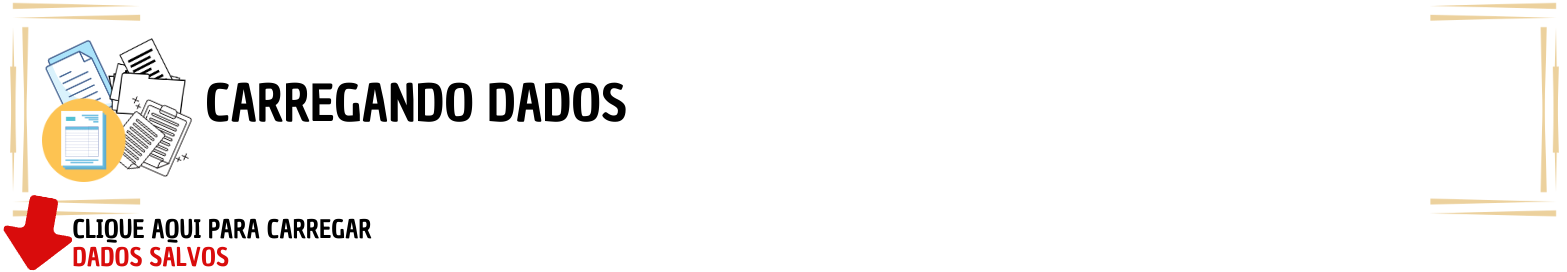

In [ ]:
# @title
import os.path
import time
from IPython.display import clear_output
from google.colab import files
from ipywidgets import interact, widgets

url_analysis = '/content/drive/MyDrive/Colab Notebooks/DataHandler/analysis'

# Lista com nomes das pastas em .../DataHandler/analysis
lista_itens = os.listdir(url_analysis)

# Contador de opções do menu
i = 1

# Lista com os números das opções do menu para verificar se alguma foi selecionada
list_opcoes = []
# Lista com os itens de cada opção (Valor da opção, Data/Hora, Comentário)
list_row = []
# Lista com as linhas da tabela de opções
list_msg = []

try:
  # Cabeçalho da tabela de opções...
  cabec = ['OPÇÃO', 'DATA/HORA', 'COMENTÁRIO']

  # Criando a lista de opções...
  for item in lista_itens:
    # Primeiro item: número da opção
    list_row.append(str(i))

    lst = item.split('|')
    lstdt = lst[0].split('-')
    dt = dtm.datetime(int(lstdt[0]), int(lstdt[1]), int(lstdt[2]))
    data = dt.strftime('%d/%m/%Y')
    hora = lst[1].split('.')

    # Segundo item: Data/Hora
    list_row.append(data + '/' + hora[0])

    # Terceiro item: Comentário
    f = open(url_analysis + '/' + item + '/coment.txt', 'r')
    list_row.append(f.read())
    f.close()

    # Adicionando os valores da opção à lista c/ linhas das mensagens
    list_msg.append(list_row)

    # Resentando lista com itens de cada opção
    list_row = []

    list_opcoes.append(item)

    i += 1
  printMessage(list_msg, cabec)
  print('\nOBS. QUALQUER VALOR DIFERENTE ENCERRA ESTA TELA\n')

  opcao = str(input('DIGITE AQUI UMA DAS OPÇÕES ACIMA E PRESSIONE "ENTER" => '))

  # Usuário selecionou um conjunto de dados salvo
  try:
    dh = DataHandler(dt=list_opcoes[int(opcao)-1])
    df_full = dh.full_df
    df_reprov = dh.reprov_df
    df_classif = dh.reprov_classif_df
    clear_output()
    print('------------------------------------------------------------------------')
    print('                     DADOS CARREGADOS COM SUCESSO')
    print('------------------------------------------------------------------------\n')
  except Exception:
    printMessage('Nenhuma opção válida foi selecionada', 'AVISO!')
  time.sleep(3)
  clear_output()
except KeyboardInterrupt:
  clear_output()
  pass

---

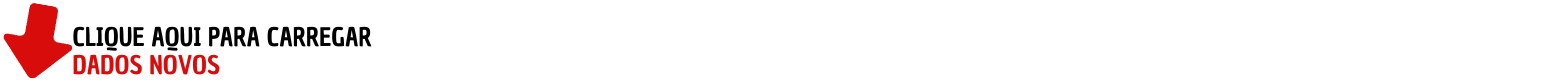

In [ ]:
# @title
from google.colab import files
from IPython.display import clear_output
import time

try:
  clear_output()
  print('------------------------------------------------------------------------------')
  print('                     SELECIONE UM PDF NO SEU COMPUTADOR')
  print('------------------------------------------------------------------------------\n')
  uploaded = files.upload()
  filename = next(iter(uploaded))
  coment = input('Digite um comentário sobre os dados e tecle ENTER (opcional):\n')
  print('------------------------------------------------------------------------------\n')
except KeyboardInterrupt:
  pass

try:
  clear_output()
  print('\n----------------------------------------------------')
  print('                     AGUARDE...')
  print('----------------------------------------------------')
  dh = DataHandler(filename=filename, coment=coment)
  df_classif = dh.classifyReprov()
  clear_output()
  print('-----------------------------------------------------')
  print('           PROCESSO CONCLUÍDO COM SUCESSO')
  print('-----------------------------------------------------')
  time.sleep(3)
  clear_output()
except KeyboardInterrupt:
  clear_output()
  pass
except Exception as e:
  clear_output()
  title = 'Um dos seguintes erros ocorreu'
  msg = ''
  msg = '- O PDF enviado é muito grande para ser processado'
  msg += '\n- O PDF enviado não possui dados no formato esperado'
  msg += '\n- O arquivo enviado não é um PDF válido'
  printMessage(msg, title)
  try:
    os.remove(filename)
  except Exception:
    clear_output()
    pass

---
---

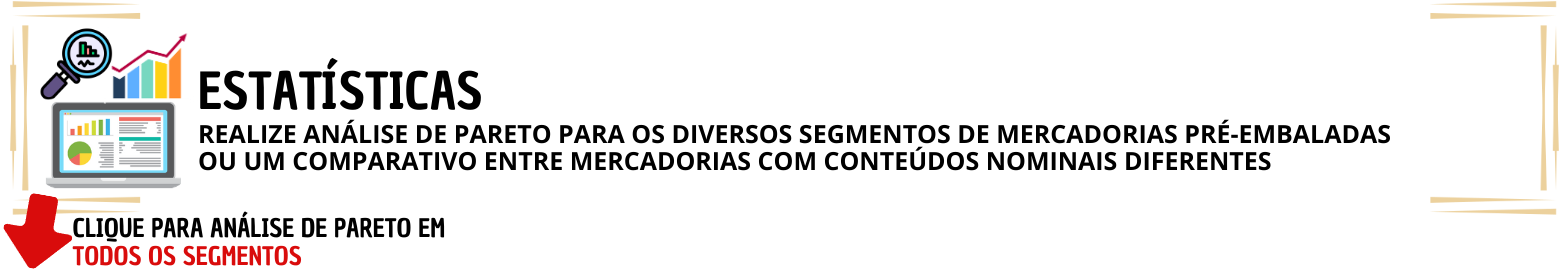
..................................................................................................................................................... Se quiser consultar a lista de segmentos [clique aqui](https://raw.githubusercontent.com/adeiltonmsantos/DataHandler/refs/heads/main/LISTA_SEGMENTOS.pdf)

In [ ]:
# @title
try:
  df_graf1 = df_classif[df_classif['segmento'] != 'Diversos']
  col1 = 'segmento'
  col2 = 'quant'
  dh.buildParetoGraph(df_graf1, 'segmento', 'quant', 'Segmento', 'Reprovações', 'Análise de Pareto para os segmentos reprovados')
except Exception as e:
  printMessage('Não há dados para exibir', 'ERRO!')
  time.sleep(4)
  clear_output()

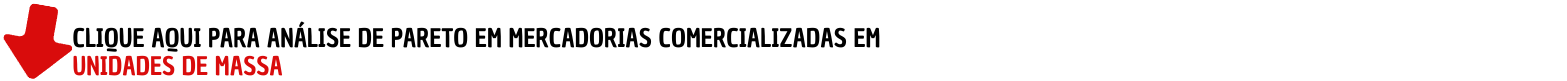

In [ ]:
# @title
try:
  df_graf2 = df_classif[df_classif['qn'].str.contains('g')]
  col1 = 'segmento'
  col2 = 'quant'
  dh.buildParetoGraph(df_graf2, 'segmento', 'quant', 'Segmento', 'Reprovações', 'Análise de Pareto - Produtos em unid. de massa')
except Exception:
  printMessage('Não há dados para exibir', 'ERRO!')
  time.sleep(4)
  clear_output()

---

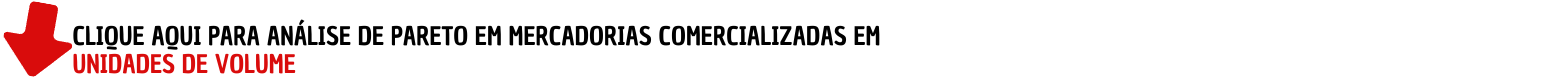

In [ ]:
# @title
try:
  df_graf3 = df_classif[df_classif['qn'].str.contains('L')]
  col1 = 'segmento'
  col2 = 'quant'
  dh.buildParetoGraph(df_graf3, 'segmento', 'quant', 'Segmento', 'Reprovações', 'Análise de Pareto - Produtos em unid. de volume')
except Exception:
  printMessage('Não há dados para exibir', 'ERRO!')
  time.sleep(4)
  clear_output()

---

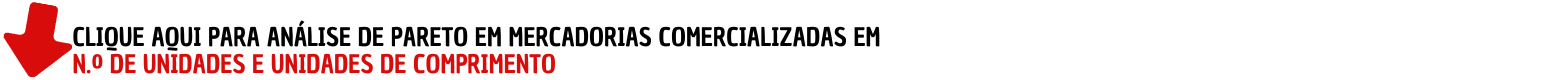

In [ ]:
# @title
try:
  df_graf4 = df_classif.query('qn.str.contains("Un") or qn.str.contains("m")')
  col1 = 'segmento'
  col2 = 'quant'
  dh.buildParetoGraph(df_graf4, 'segmento', 'quant', 'Segmento', 'Reprovações', 'Análise de Pareto - Produtos em N.º unid. e unid. de comprimento')
except Exception:
  printMessage('Não há dados para exibir', 'ERRO!')
  time.sleep(4)
  clear_output()

---

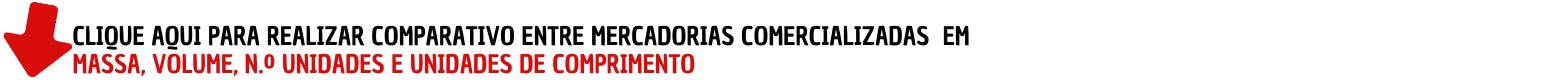

In [ ]:
# @title
try:
  rp_massa = df_classif[df_classif['qn'].str.contains('g')]
  rp_volume = df_classif[df_classif['qn'].str.contains('L')]
  rp_unid_comp = df_classif.query('qn.str.contains("Un") or qn.str.contains("m")')

  tot_mass = rp_massa.count()['quant']
  tot_vol = rp_volume.count()['quant']
  tot_unid_comp = rp_unid_comp.count()['quant']
  tot_geral = tot_mass + tot_vol + tot_unid_comp

  lst_vl = [tot_mass*100/tot_geral, tot_vol*100/tot_geral, tot_unid_comp*100/tot_geral]
  df = pd.DataFrame(lst_vl, index=['Massa', 'Volume', 'Unid. e Comprimento'], columns=['Reprov'])
  df.sort_values(by='Reprov', ascending=False, inplace=True)
  ax = df.plot(kind='bar', legend=None, title='Percentual de reprovação por tipo de produto')
  for i, v in enumerate(df['Reprov']):
      ax.text(i, v, str(round(v, 2)) + '%', ha='center', va='bottom')
except Exception:
  printMessage('Não há dados para exibir', 'ERRO!')
  time.sleep(4)
  clear_output()

---
---